In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import numpy as np
from pyuvdata import UVCal, UVData
import os
import sys
import glob
import uvtools as uvt
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, Angle
from astropy.coordinates import SkyCoord as sc
import pandas
import warnings 
import copy
from hera_notebook_templates import utils
import hera_qm
from hera_mc import cm_hookup
import h5py
import importlib
from scipy import stats
#warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
#get data location
JD = os.environ['JULIANDATE']
data_path = os.environ['DATA_PATH']
ant_metrics_ext = os.environ['ANT_METRICS_EXT']
utc = Time(JD, format='jd').datetime
print(f'JD = {JD}')
print(f'Date = {utc.month}-{utc.day}-{utc.year}')
print(f'data_path = "{data_path}"')
print(f'ant_metrics_ext = "{ant_metrics_ext}"')

JD = 2459115
Date = 9-22-2020
data_path = "/mnt/sn1"
ant_metrics_ext = ".known_good.ant_metrics.hdf5"


In [3]:
# Load in data
HHfiles, difffiles, HHautos, diffautos, uvdx, uvdy = utils.load_data(data_path,JD)
ant_metrics_list = [df.replace('.uvh5', ant_metrics_ext) for df in HHfiles]
with h5py.File(ant_metrics_list[0], "r") as infile:
    xants = [int(ant) for ant in infile['Header']['history'][()].decode().split('--apriori_xants')[-1].strip().split(' ')]
    
uvd = UVData()
unread = True
readInd=0
while unread and readInd<len(HHautos):
    try:
        uvd.read(HHautos[readInd])
        unread = False
    except:
        readInd += 1
        continue
use_ants = [int(ant) for ant in uvd.antenna_numbers if ant not in xants]
uvd.read(HHautos[::10], skip_bad_files=True, antenna_nums = use_ants)
lsts = uvd.lst_array
uvdx.select(antenna_nums=use_ants)
uvdy.select(antenna_nums=use_ants)

OSError: Unable to open file (unable to open file: name = '/mnt/sn1/zen.2459115.51984.sum.known_good.ant_metrics.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## Sky Coverage Map 

Map of the sky (made using the Haslam 408MHz map). The RA/DEC range covered by this night of observation is shaded based on a 12 degree FWHM of the beam. Horizontal dashed lines represent the stripe that HERA can observe, while the shaded region is what was observed on this night. Vertical lines represent the beginning and ending LSTs of this observation. Selected sources are labelled, sources included are those in the GLEAM 4Jy catalog with a flux >10.9 Jy. Note that the map is clipped at the northern horizon.

In [4]:
sources = utils.gather_source_list()
utils.plot_sky_map(uvd,dec_pad=55,ra_pad=55,clip=False,sources=sources)

NameError: name 'uvd' is not defined

## LST Coverage

Shows the LSTs (in hours) and JDs for which data is collected. Green represents data, red means no data.

In [5]:
utils.plot_lst_coverage(uvd)

NameError: name 'uvd' is not defined

## Autocorrelations for a single file

This plot shows autocorrelations for one timestamp of each antenna that is active and each polarization. For each node, antennas are ordered by SNAP number, and within that by SNAP input number. The antenna number label color corresponds to the a priori status of that antenna.

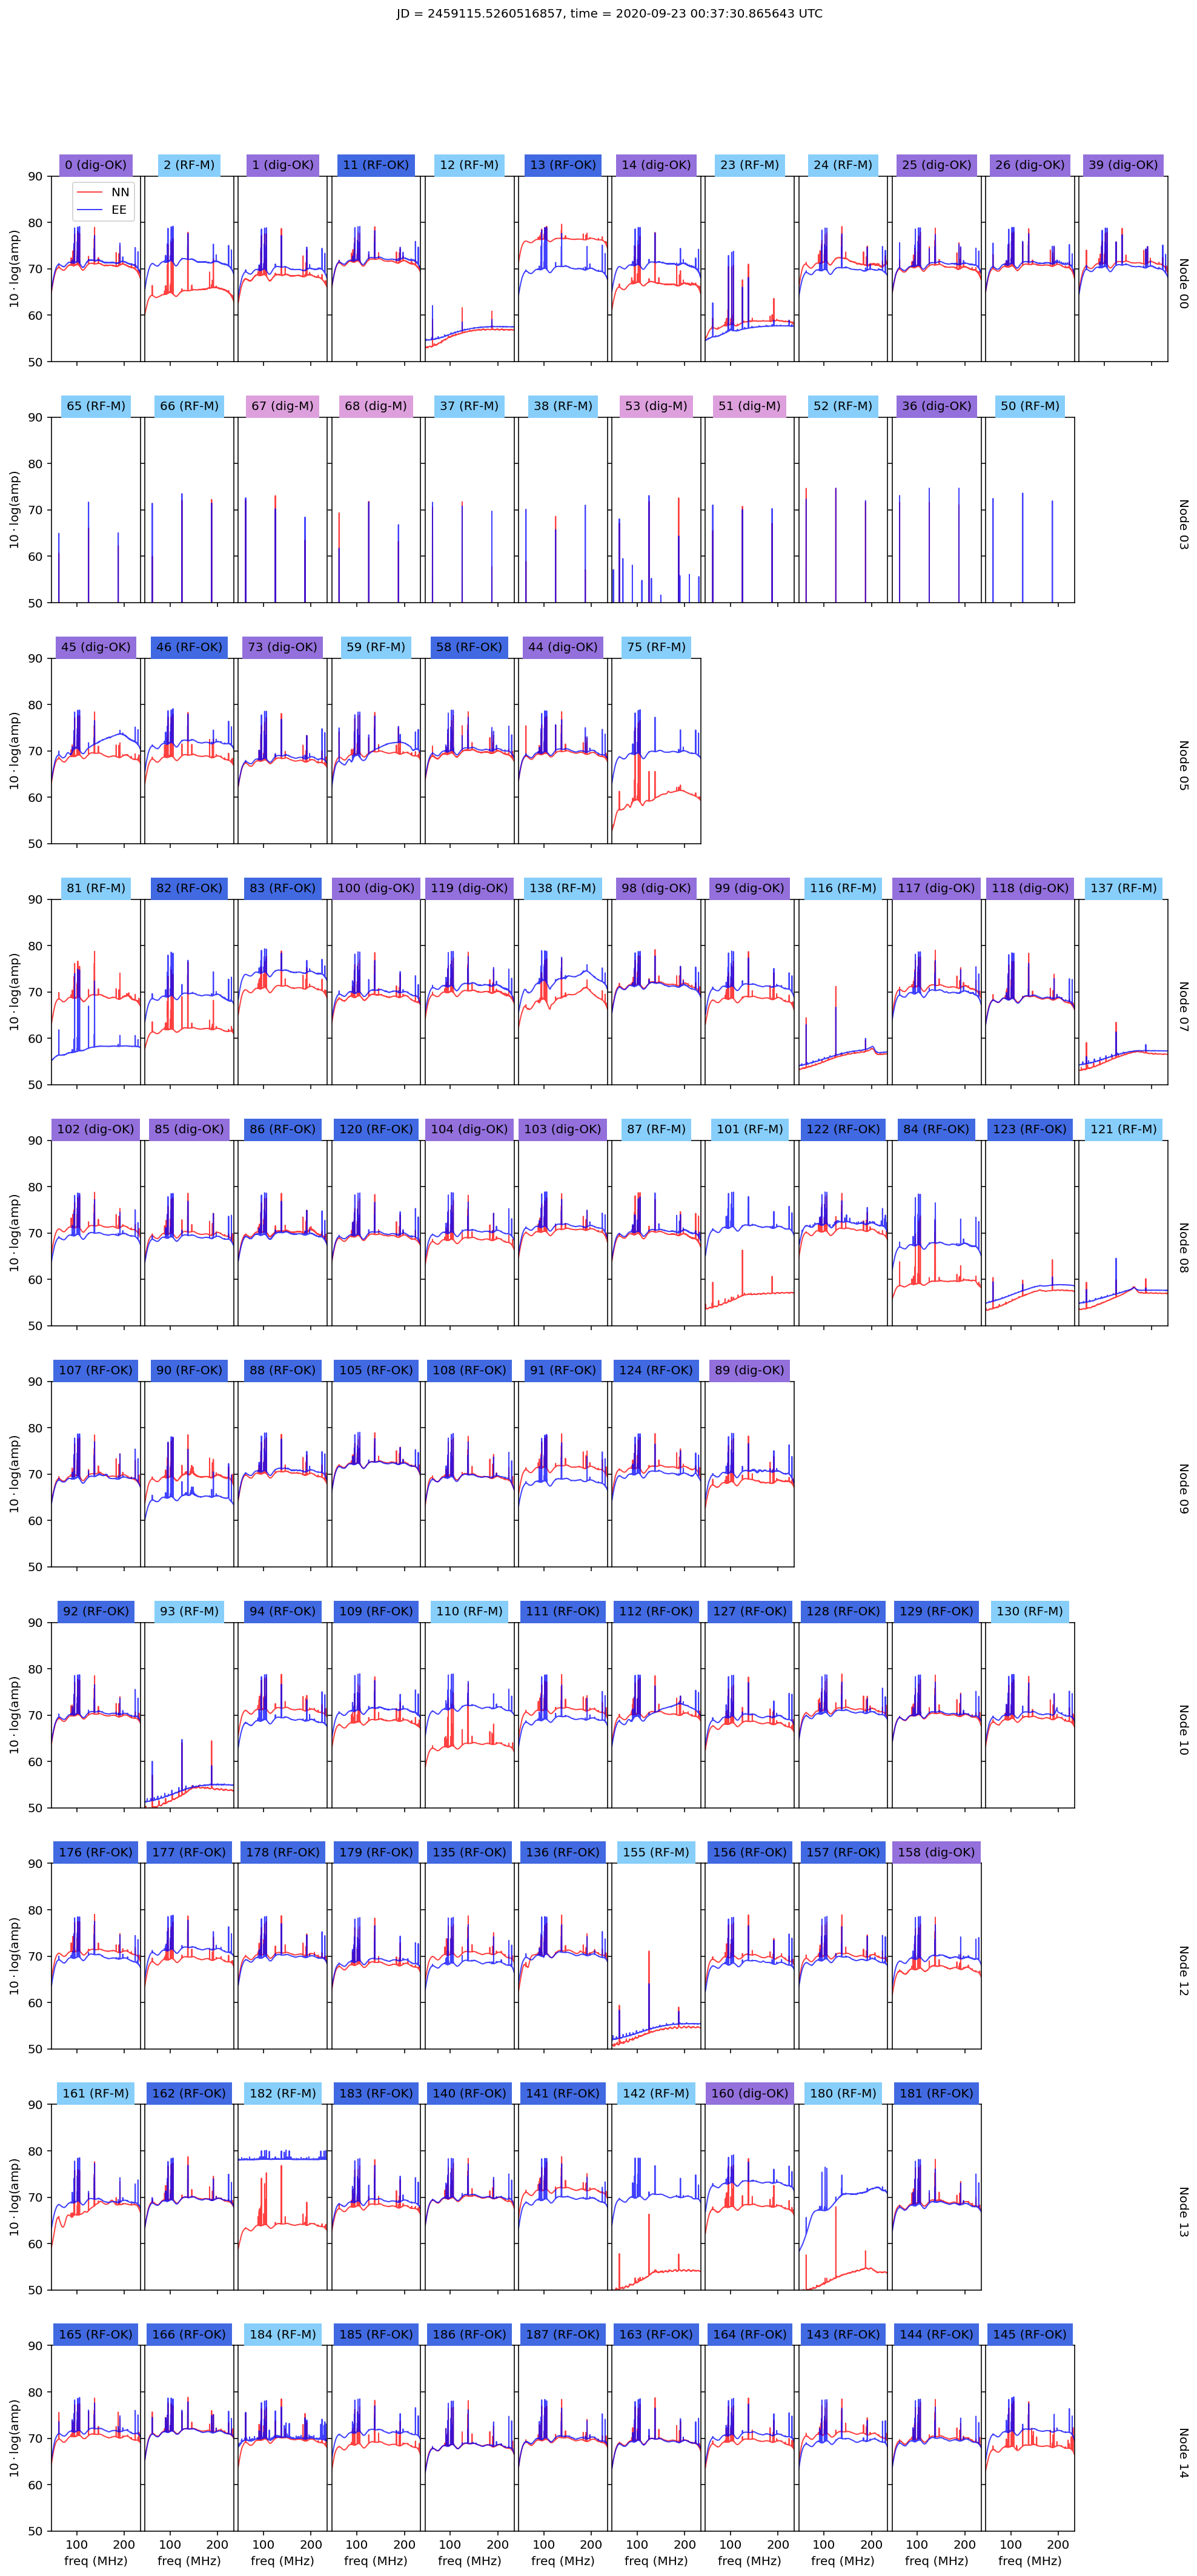

In [6]:
### plot autos
utils.plot_autos(uvdx, uvdy)

## Waterfalls of Autocorrelation Amplitudes for each Antenna and Each polarization

These plots show autocorrelation waterfalls of each antenna that is active and whose status qualifies for this notebook. For each node, antennas are ordered by SNAP number, and within that by SNAP input number. The antenna number label color corresponds to the a priori status of that antenna.

In [7]:
utils.plot_wfs(uvd, pol = 0)

NameError: name 'uvd' is not defined

In [8]:
utils.plot_wfs(uvd, pol = 1)

NameError: name 'uvd' is not defined

## Correlation Metrics

The first plot shows the correlation metric (described below) for a set of baseline types, as calculated at several times throughout the night. It is expected that longer baselines (darker color) will exhibit lower values than the short baselines. 

The matrices show the phase correlation between antennas. Using the even and odd visibilities, each pixel is calculated as (even/abs(even)) * (conj(odd)/abs(odd)), and then averaged across time and frequency. If the phases are noise-like, this value will average down to zero. If the antennas are well correlated, the phases should not be noise-like, and this value should average to 1. The lines denoting node boundaries are intended to help confirm that inter-node correlations are functioning - if they aren't, this plot will appear block-diagonal.

This metric has shown to be LST locked - when comparing to other nights, be sure to compare for the same LST. It is expected that some LSTs will look much better or worse than others.

Note: Within each node, the order of antennas is determined by snap, and within that by snap input number. 

In [9]:
badAnts = []
badAnts = utils.plotNodeAveragedSummary(uvd,HHfiles,JD,use_ants,mat_pols=['xx','yy','xy','yx'])

NameError: name 'uvd' is not defined

Visibility amplitude spectra for a set of redundant baselines, labeled by inter vs. intranode baselines. The red and blue should exhibit the same bandpass shape - if the red are consistently different from the blue, this indicates an issue with internode correlations.

Note: antennas that were identified as bad by the correlation matrix have been removed from this plot.

In [10]:
utils.plotVisibilitySpectra(HHfiles[len(HHfiles)//2+1], JD, use_ants, badAnts=badAnts)

NameError: name 'use_ants' is not defined

## Even and Odd File Checks

A waterfall showing the ratio between the even and odd visibilities. The purpose of this is to highlight xengine failures, which will cause this value to fall to zero or go to infinity. If things are working properly, this value should be stable at 1. The boundaries between different x-engines are shown by the vertical white lines.

In [11]:
if len(HHautos) == len(diffautos):
    uvd_diff = UVData()
    uvd_diff.read(diffautos[::10], skip_bad_files=True, antenna_nums=use_ants)
    rat = utils.plotEvenOddWaterfalls(uvd,uvd_diff)
else:
    uvd_diff = UVData()
    use_diffs = [f for f in diffautos if '%s/zen.%s.%s.sum.autos.uvh5' % (data_path,f.split('.')[1],f.split('.')[2]) in HHautos[::10]]
    uvd_diff.read(use_diffs, skip_bad_files=True, antenna_nums = use_ants)
    uvd_sum = uvd.select(times=np.unique(uvd_diff.time_array),inplace=False)
    rat = utils.plotEvenOddWaterfalls(uvd_sum,uvd_diff)

NameError: name 'use_ants' is not defined

## Antenna Metrics Over a Whole Night

In [12]:
ant_metrics_list = [df.replace('.uvh5', ant_metrics_ext) for df in HHfiles]
apriori_exants = {}
am_xants_dict = {}
am_dead_ants_dict = {}
am_crossed_ants_dict = {}
for amf in ant_metrics_list:
    try:
        with h5py.File(amf, "r") as infile:
            xants = infile['Metrics']['xants'][:]
            dead_ants = infile['Metrics']['dead_ants'][:]
            crossed_ants = infile['Metrics']['crossed_ants'][:]        
            ex_ants_string = infile['Header']['history'][()].decode()
            ex_ants_string = ex_ants_string.split('--apriori_xants')[1]
            ex_ants_string = ex_ants_string.split('--')[0].strip()
    except:
        print(f'skipping {amf}')
        continue
        
    am_xants_dict[amf] = [(int(ant[0]), ant[1].decode()) for ant in xants]
    am_dead_ants_dict[amf] = [(int(ant[0]), ant[1].decode()) for ant in dead_ants]
    am_crossed_ants_dict[amf] = [(int(ant[0]), ant[1].decode()) for ant in crossed_ants]
    apriori_exants[amf] = [int(ant) for ant in ex_ants_string.split()]


file = HHfiles[0]
uvd_hh = UVData()
uvd_hh.read_uvh5(file)
uvdx = uvd_hh.select(polarizations = -5, inplace = False)
uvdx.ants = np.unique(np.concatenate([uvdx.ant_1_array, uvdx.ant_2_array]))
antstemp = uvdx.get_ants()
ants = []

for ant in antstemp:
    ants.append((ant,'Jee'))
    ants.append((ant, 'Jnn'))

skipping /mnt/sn1/zen.2459115.51984.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52007.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52029.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52052.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52074.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52096.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52119.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52141.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52163.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52186.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52208.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52230.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52253.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52275.sum.known_good.ant_metrics.hdf5
skipping /mnt/sn1/zen.2459115.52298.sum.known_go

In [13]:
exants_grid = np.zeros((len(ants),len(HHfiles))) + 4.0
ant_flags_dict = []
flaggedAnts = {}
color_order = ['gold', 'magenta', 'cyan', 'black']

# 0 = apriori, 1 = AM dead, 2 =  AM crossed, 3 = redcal, 4 = no flags 
for f, cal in enumerate(ant_flags_dict):
    for i, ant in enumerate(ants):
        if ant_flags_dict[cal][ant]:
            exants_grid[i, f] = 3.0
for f, amf in enumerate(am_xants_dict):
    for i, ant in enumerate(ants):
        if ant in am_dead_ants_dict[amf]:
            exants_grid[i, f] = 1.0   
        elif ant in am_crossed_ants_dict[amf]:
            exants_grid[i, f] = 2.0
for f, amf in enumerate(apriori_exants):
    for i, ant in enumerate(ants):
        if ant[0] in apriori_exants[amf]:
            exants_grid[i, f] = 0.0
            
for i,ant in enumerate(ants):
    m = int(stats.mode(exants_grid[i,:]).mode)
    if m != 4:
        flaggedAnts[ant[0]] = color_order[m]

from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap = matplotlib.colors.ListedColormap(color_order)
bounds=np.arange(len(color_order)+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
            
fig = plt.figure(figsize=(14,len(ants)/4.625))
im = plt.imshow(exants_grid, aspect='auto', cmap=cmap, norm=norm, interpolation='nearest',
                extent=[lsts[0]*12/np.pi, lsts[-1]*12/np.pi, len(ants), 0])
plt.yticks(np.arange(len(ants))+.5, 
           labels = ['{}{}'.format(ant[0], ant[1][-1]) for ant in ants]);
plt.grid(color='w', linestyle='-', linewidth=1.5, axis='y')
plt.xlabel('LST (Hours)')

divider = make_axes_locatable(plt.gca())
cax = divider.new_vertical(size=.4, pad=0.5, pack_start=False)
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.set_ticks(.5 + np.arange(len(color_order)))
cbar.set_ticklabels(['Flagged A Priori', 
                     'Flagged by AM as Dead',
                     'Flagged by AM as Crossed',
                     'No Flags', ])

NameError: name 'lsts' is not defined

<Figure size 1008x3238.05 with 0 Axes>

## Crossed Antenna Check

These are differences between different panels of the correlation matrices shown above (see panel titles for specifics). Antennas showing as consistently blue are ones which are correlating stronger in the cross pols than in the auto pols, indicating that the antenna polarizations are likely crossed.

In [14]:
crossedAnts = utils.plotNodeAveragedSummary(uvd,HHfiles,JD,use_ants,mat_pols=['xx','yy','xy','yx'],plotRatios=True,
                                       plotSummary=False)

NameError: name 'uvd' is not defined

## Antenna Positions

Antennas outlined in black here have been identified by the correlation matrix as bad antennas. Antennas with a colorful outline correspond to their status as identified by ant_metrics (see above plot). Faded antennas are those not meeting the apriori status requirement for this notebook run. Gold stars are node box locations.

In [15]:
uvd1 = UVData()
uvd1.read(HHfiles[readInd], skip_bad_files=True)
utils.plot_antenna_positions(uvd1, badAnts=badAnts,flaggedAnts=flaggedAnts,use_ants=use_ants)

NameError: name 'readInd' is not defined

## Observer Inspection Plots

Antennas of status digital_OK or better that are flagged as bad by any of the above metrics are plotted here so observers can inspect their failures in more detail. Additionally, a 'good' template has been used to identify outliers. The upper line plots are averages over the whole observation, and the lower line plots are slices of a single time in the middle of the observation. These plots are recommended diagnostics for demoting antennas to lower statuses or reporting issues. If the plots below look OK, check other plots in notebook to hunt why the antenna was flagged. NOTE: The colorbar/power scales in these plots are NOT locked between antennas OR polarizations so that the detail will be visible on all plots. Be sure to check for reasonable power levels, as this may be the reason the antenna was flagged for inspection.

In [16]:
d, tempAnts = utils.flag_by_template(uvd,HHautos,JD,use_ants=use_ants,pols=['XX','YY'],plotMap=False)

NameError: name 'uvd' is not defined

In [17]:
inspectAnts = utils.plot_inspect_ants(uvd,JD,badAnts=badAnts,flaggedAnts=flaggedAnts,use_ants=use_ants,
                                     tempAnts=tempAnts,crossedAnts=crossedAnts)

NameError: name 'uvd' is not defined

## Mean-Subtracted Waterfalls

Here the mean value in each frequency bin has been subtracted out. This effectively subtracts out the bandpass shape, making time variations more visible.

In [18]:
utils.plot_mean_subtracted_wfs(uvd,use_ants,JD)

NameError: name 'uvd' is not defined

## Delay spectrum

Delay spectrum CLEANed using uvtools.dspec.high_pass_fourier_filter with 7th-order Blackman-Harris window function and full frequency band. All delay spectra except for waterfalls are incoherently averaged over ~1h (if the observation is longer than 1h) with odd/even visibilities to remove noise bias.

In [19]:
# bls = [(ant,ant) for ant in np.sort(uvd.get_ants())]
# _data_sq, data_rs, uvd_ds, uvd_diff = utils.clean_ds(HHfiles, difffiles, bls)

Diagnosis of delay spectra for three different delay regions:

Top panel: compute delay spectrum over 250-500 ns

Middle panel: compute standard deviation ratio $\sigma_{2500-3000}/\sigma_{3000-3200}$ to see the presence of spike at 2500-3000 ns. ~1 in y-axis (dashed line) means there is no spike, and >1 may indicate the presence of spike in the region

Bottom panel: compute distance between delay spectrum and noise level at large delay (3500-4000 ns). ~0 (dashed line) means the delay spectrum can go down to the noise level

In [20]:
# utils.plot_ds_diagnosis(uvd_diff, _data_sq)

In [21]:
# utils.plot_ds_nodes(uvd_diff, _data_sq)

In [22]:
# utils.plot_wfds(uvd_ds, _data_sq, 'ee')

In [23]:
# utils.plot_wfds(uvd_ds, _data_sq, 'nn')

These plots show incoherently averaged (~1h) delay spectra, autocorrelations and clean residuals for each antenna.

Left panel: delay spectra of autocorrelations, averaged noises from diff files (|$<\tilde{\Delta}>_{\rm t}$|, thiner fluctuating lines). The variance of the delay spectrum is also shown ($\sqrt{<|\tilde{\Delta}|^2>_{\rm t}/(2N_{\rm t})}$) which is consistent with the average of diff. Three shaded zones are those explained in the above diagnosis plots.
    
Top right: autocorrelations w/o and w/ flagging. Autocorrelations are normalized to have median=1. Flagged ones are shifted for clarity.
    
Bottom right: clean residuals normalized by the autocorrelations. If there are unflagged RFIs, which may affect the delay spectrum, we may see remaining RFI more clearly in the plot.

In [24]:
# utils.plot_ds(uvd_ds, uvd_diff, _data_sq, data_rs)

In [25]:
# bls_cr = [(uvd.get_ants()[0],ant) for ant in np.sort(uvd.get_ants())][1:]
# _data_sq_cr, data_rs_cr, uvd_cr, uvd_diff_cr = utils.clean_ds(HHfiles, difffiles, bls_cr)

Waterfalls for delay spectrum of crosscorrelation with a reference antenna

In [26]:
# utils.plot_wfds_cr(uvd_cr, _data_sq_cr, 'ee')

In [27]:
# utils.plot_wfds_cr(uvd_cr, _data_sq_cr, 'nn')